<a href="https://colab.research.google.com/github/anuragal/deep-learning/blob/master/S7/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [68]:
class ImageData(object):

  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog',
			'frog', 'horse', 'ship', 'truck')

  def __init__(self):
    super(ImageData, self).__init__()

  def load(self):
   transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
   
   SEED = 1

   # CUDA?
   cuda = torch.cuda.is_available()
   print("CUDA Available?", cuda)

   # For reproducibility
   torch.manual_seed(SEED)

   if cuda:
     torch.cuda.manual_seed(SEED)

   # dataloader arguments - something you'll fetch these from cmdprmt
   dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

   trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

   testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

   self.trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
   self.testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

img_data = ImageData()
img_data.load()


CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



plane   dog  deer  deer


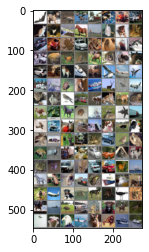

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(img_data.trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % img_data.classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_value = 0.1

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 32x32x3 | Out: 32x32x32 | RF: 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # In: 32x32x32 | Out: 32x32x32 | RF: 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # In: 32x32x32 | Out: 16x16x12 | RF: 6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, groups=32, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 16x16x32 | Out: 16x16x32 | RF: 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        ) # In: 16x16x32 | Out: 16x16x64 | RF: 14

        # TRANSITION BLOCK 1
        self.pool2 = nn.MaxPool2d(2, 2) # In: 16x16x32 | Out: 8x8x32 | RF: 16

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, dilation=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 8x8x64 | Out: 8x8x64 | RF: 24
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        ) # In: 8x8x64 | Out: 8x8x128 | RF: 32

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=1)
        ) # In: 8x8x128 | Out: 1x1x128 | RF: 40
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # In: 1x1x128 | Out: 1x1x10 | RF: 56


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

net = Net()

## Model

In [71]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]             288
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             ReLU-12           [-1, 32, 16, 16]               0
          Dropout-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [0]:
from tqdm import tqdm

train_losses = []
train_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, test_losses, test_acc, misclassified, cal_misclassified = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            if cal_misclassified == True:
                for i in range(len(pred)):
                    if pred[i] != target[i]:
                        misclassified.append([data[i], pred[i], target[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_losses, test_acc, misclassified

In [0]:
from torch.optim.lr_scheduler import StepLR

matrix_data = {}

EPOCHS = 2

def run_model(data_key, l1_decay = 0.4, l2_decay = 0.16, cal_misclassified = False):
    net_model = Net()

    model =  net_model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    test_losses = []
    test_acc = []
    misclassified = []
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch + 1)
        train(model, device, img_data.trainloader, optimizer, epoch)
        scheduler.step()
        test_losses, test_acc, misclassified = test(model, device, img_data.testloader, test_losses, test_acc, misclassified, cal_misclassified = cal_misclassified)
    matrix_data[data_key] = {"loss":test_losses, "accuracy":test_acc, "misclassified":misclassified}

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



In [83]:
run_model( "BN", cal_misclassified = True)


  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1



Loss=2.3064417839050293 Batch_id=0 Accuracy=10.94:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=2.3064417839050293 Batch_id=0 Accuracy=10.94:   0%|          | 1/391 [00:00<02:06,  3.07it/s]
Loss=2.320011854171753 Batch_id=1 Accuracy=10.16:   0%|          | 1/391 [00:00<02:06,  3.07it/s] 
Loss=2.2792837619781494 Batch_id=2 Accuracy=12.76:   0%|          | 1/391 [00:00<02:06,  3.07it/s]
Loss=2.258697271347046 Batch_id=3 Accuracy=13.67:   0%|          | 1/391 [00:00<02:06,  3.07it/s] 
Loss=2.258697271347046 Batch_id=3 Accuracy=13.67:   1%|          | 4/391 [00:00<01:32,  4.17it/s]
Loss=2.286165475845337 Batch_id=4 Accuracy=14.53:   1%|          | 4/391 [00:00<01:32,  4.17it/s]
Loss=2.237664222717285 Batch_id=5 Accuracy=15.89:   1%|          | 4/391 [00:00<01:32,  4.17it/s]
Loss=2.2444517612457275 Batch_id=6 Accuracy=16.41:   1%|          | 4/391 [00:00<01:32,  4.17it/s]
Loss=2.2444517612457275 Batch_id=6 Accuracy=16.41:   2%|▏         | 7/391 [00:00<01:08,  5.60it/s]
Loss=2.1976587772369


Test set: Average loss: 1.1686, Accuracy: 5847/10000 (58.47%)

EPOCH: 2



Loss=1.1126035451889038 Batch_id=0 Accuracy=57.81:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=1.1126035451889038 Batch_id=0 Accuracy=57.81:   0%|          | 1/391 [00:00<01:59,  3.25it/s]
Loss=1.1755098104476929 Batch_id=1 Accuracy=55.86:   0%|          | 1/391 [00:00<01:59,  3.25it/s]
Loss=1.16007661819458 Batch_id=2 Accuracy=54.95:   0%|          | 1/391 [00:00<01:59,  3.25it/s]  
Loss=1.0412567853927612 Batch_id=3 Accuracy=58.20:   0%|          | 1/391 [00:00<01:59,  3.25it/s]
Loss=1.202573537826538 Batch_id=4 Accuracy=57.81:   0%|          | 1/391 [00:00<01:59,  3.25it/s] 
Loss=1.202573537826538 Batch_id=4 Accuracy=57.81:   1%|▏         | 5/391 [00:00<01:27,  4.43it/s]
Loss=1.2137748003005981 Batch_id=5 Accuracy=57.55:   1%|▏         | 5/391 [00:00<01:27,  4.43it/s]
Loss=1.1185638904571533 Batch_id=6 Accuracy=58.04:   1%|▏         | 5/391 [00:00<01:27,  4.43it/s]
Loss=1.0866390466690063 Batch_id=7 Accuracy=58.59:   1%|▏         | 5/391 [00:00<01:27,  4.43it/s]
Loss=1.08663904666


Test set: Average loss: 0.8954, Accuracy: 6791/10000 (67.91%)

EPOCH: 3



Loss=0.8658291697502136 Batch_id=0 Accuracy=68.75:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.8658291697502136 Batch_id=0 Accuracy=68.75:   0%|          | 1/391 [00:00<01:52,  3.47it/s]
Loss=0.8453353643417358 Batch_id=1 Accuracy=71.09:   0%|          | 1/391 [00:00<01:52,  3.47it/s]
Loss=0.7604862451553345 Batch_id=2 Accuracy=72.14:   0%|          | 1/391 [00:00<01:52,  3.47it/s]
Loss=0.8308244943618774 Batch_id=3 Accuracy=70.90:   0%|          | 1/391 [00:00<01:52,  3.47it/s]
Loss=0.8384406566619873 Batch_id=4 Accuracy=71.09:   0%|          | 1/391 [00:00<01:52,  3.47it/s]
Loss=0.8384406566619873 Batch_id=4 Accuracy=71.09:   1%|▏         | 5/391 [00:00<01:21,  4.71it/s]
Loss=1.0681300163269043 Batch_id=5 Accuracy=70.18:   1%|▏         | 5/391 [00:00<01:21,  4.71it/s]
Loss=0.8243842124938965 Batch_id=6 Accuracy=70.09:   1%|▏         | 5/391 [00:00<01:21,  4.71it/s]
Loss=0.7679864764213562 Batch_id=7 Accuracy=70.61:   1%|▏         | 5/391 [00:00<01:21,  4.71it/s]
Loss=0.7679864764


Test set: Average loss: 0.8233, Accuracy: 7159/10000 (71.59%)

EPOCH: 4



Loss=0.6484624743461609 Batch_id=0 Accuracy=80.47:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.6484624743461609 Batch_id=0 Accuracy=80.47:   0%|          | 1/391 [00:00<01:58,  3.28it/s]
Loss=0.6863232254981995 Batch_id=1 Accuracy=78.12:   0%|          | 1/391 [00:00<01:58,  3.28it/s]
Loss=0.6348801851272583 Batch_id=2 Accuracy=77.60:   0%|          | 1/391 [00:00<01:58,  3.28it/s]
Loss=0.6948913931846619 Batch_id=3 Accuracy=76.95:   0%|          | 1/391 [00:00<01:58,  3.28it/s]
Loss=0.6948913931846619 Batch_id=3 Accuracy=76.95:   1%|          | 4/391 [00:00<01:27,  4.45it/s]
Loss=0.7149861454963684 Batch_id=4 Accuracy=76.41:   1%|          | 4/391 [00:00<01:27,  4.45it/s]
Loss=0.7790870070457458 Batch_id=5 Accuracy=75.91:   1%|          | 4/391 [00:00<01:27,  4.45it/s]
Loss=0.661652147769928 Batch_id=6 Accuracy=75.89:   1%|          | 4/391 [00:00<01:27,  4.45it/s] 
Loss=0.661652147769928 Batch_id=6 Accuracy=75.89:   2%|▏         | 7/391 [00:00<01:05,  5.86it/s]
Loss=0.82596105337


Test set: Average loss: 0.7382, Accuracy: 7468/10000 (74.68%)

EPOCH: 5



Loss=0.6495089530944824 Batch_id=0 Accuracy=75.78:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.6495089530944824 Batch_id=0 Accuracy=75.78:   0%|          | 1/391 [00:00<01:40,  3.89it/s]
Loss=0.6914883852005005 Batch_id=1 Accuracy=75.00:   0%|          | 1/391 [00:00<01:40,  3.89it/s]
Loss=0.7700527310371399 Batch_id=2 Accuracy=75.52:   0%|          | 1/391 [00:00<01:40,  3.89it/s]
Loss=0.7700527310371399 Batch_id=2 Accuracy=75.52:   1%|          | 3/391 [00:00<01:16,  5.10it/s]
Loss=0.6889195442199707 Batch_id=3 Accuracy=75.39:   1%|          | 3/391 [00:00<01:16,  5.10it/s]
Loss=0.7810711860656738 Batch_id=4 Accuracy=75.31:   1%|          | 3/391 [00:00<01:16,  5.10it/s]
Loss=0.6604384779930115 Batch_id=5 Accuracy=75.39:   1%|          | 3/391 [00:00<01:16,  5.10it/s]
Loss=0.6604384779930115 Batch_id=5 Accuracy=75.39:   2%|▏         | 6/391 [00:00<00:57,  6.64it/s]
Loss=0.6280278563499451 Batch_id=6 Accuracy=75.67:   2%|▏         | 6/391 [00:00<00:57,  6.64it/s]
Loss=0.7482865452


Test set: Average loss: 0.6873, Accuracy: 7590/10000 (75.90%)

EPOCH: 6



Loss=0.5371004343032837 Batch_id=0 Accuracy=81.25:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5371004343032837 Batch_id=0 Accuracy=81.25:   0%|          | 1/391 [00:00<01:37,  4.02it/s]
Loss=0.6116347908973694 Batch_id=1 Accuracy=79.69:   0%|          | 1/391 [00:00<01:37,  4.02it/s]
Loss=0.6178813576698303 Batch_id=2 Accuracy=79.43:   0%|          | 1/391 [00:00<01:37,  4.02it/s]
Loss=0.7193688750267029 Batch_id=3 Accuracy=77.93:   0%|          | 1/391 [00:00<01:37,  4.02it/s]
Loss=0.6421061754226685 Batch_id=4 Accuracy=77.97:   0%|          | 1/391 [00:00<01:37,  4.02it/s]
Loss=0.6421061754226685 Batch_id=4 Accuracy=77.97:   1%|▏         | 5/391 [00:00<01:11,  5.42it/s]
Loss=0.7332437038421631 Batch_id=5 Accuracy=78.65:   1%|▏         | 5/391 [00:00<01:11,  5.42it/s]
Loss=0.6245254874229431 Batch_id=6 Accuracy=78.46:   1%|▏         | 5/391 [00:00<01:11,  5.42it/s]
Loss=0.6592011451721191 Batch_id=7 Accuracy=78.42:   1%|▏         | 5/391 [00:00<01:11,  5.42it/s]
Loss=0.6592011451


Test set: Average loss: 0.6520, Accuracy: 7696/10000 (76.96%)

EPOCH: 7



Loss=0.66362464427948 Batch_id=0 Accuracy=73.44:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.66362464427948 Batch_id=0 Accuracy=73.44:   0%|          | 1/391 [00:00<02:04,  3.13it/s]
Loss=0.6405300498008728 Batch_id=1 Accuracy=75.78:   0%|          | 1/391 [00:00<02:04,  3.13it/s]
Loss=0.602156937122345 Batch_id=2 Accuracy=75.78:   0%|          | 1/391 [00:00<02:04,  3.13it/s] 
Loss=0.6960387229919434 Batch_id=3 Accuracy=75.59:   0%|          | 1/391 [00:00<02:04,  3.13it/s]
Loss=0.6960387229919434 Batch_id=3 Accuracy=75.59:   1%|          | 4/391 [00:00<01:31,  4.24it/s]
Loss=0.5826593041419983 Batch_id=4 Accuracy=76.72:   1%|          | 4/391 [00:00<01:31,  4.24it/s]
Loss=0.7278249263763428 Batch_id=5 Accuracy=76.04:   1%|          | 4/391 [00:00<01:31,  4.24it/s]
Loss=0.5366198420524597 Batch_id=6 Accuracy=77.01:   1%|          | 4/391 [00:00<01:31,  4.24it/s]
Loss=0.76560378074646 Batch_id=7 Accuracy=76.56:   1%|          | 4/391 [00:00<01:31,  4.24it/s]  
Loss=0.76560378074646


Test set: Average loss: 0.5614, Accuracy: 8051/10000 (80.51%)

EPOCH: 8



Loss=0.5340271592140198 Batch_id=0 Accuracy=82.81:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5340271592140198 Batch_id=0 Accuracy=82.81:   0%|          | 1/391 [00:00<02:00,  3.23it/s]
Loss=0.5088355541229248 Batch_id=1 Accuracy=81.64:   0%|          | 1/391 [00:00<02:00,  3.23it/s]
Loss=0.5183380246162415 Batch_id=2 Accuracy=82.29:   0%|          | 1/391 [00:00<02:00,  3.23it/s]
Loss=0.4841933846473694 Batch_id=3 Accuracy=82.03:   0%|          | 1/391 [00:00<02:00,  3.23it/s]
Loss=0.4841933846473694 Batch_id=3 Accuracy=82.03:   1%|          | 4/391 [00:00<01:28,  4.37it/s]
Loss=0.5866602063179016 Batch_id=4 Accuracy=81.56:   1%|          | 4/391 [00:00<01:28,  4.37it/s]
Loss=0.49186357855796814 Batch_id=5 Accuracy=81.12:   1%|          | 4/391 [00:00<01:28,  4.37it/s]
Loss=0.6506409049034119 Batch_id=6 Accuracy=81.03:   1%|          | 4/391 [00:00<01:28,  4.37it/s] 
Loss=0.6506409049034119 Batch_id=6 Accuracy=81.03:   2%|▏         | 7/391 [00:00<01:06,  5.81it/s]
Loss=0.43504935


Test set: Average loss: 0.5538, Accuracy: 8088/10000 (80.88%)

EPOCH: 9



Loss=0.49248337745666504 Batch_id=0 Accuracy=83.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.49248337745666504 Batch_id=0 Accuracy=83.59:   0%|          | 1/391 [00:00<01:34,  4.12it/s]
Loss=0.35340628027915955 Batch_id=1 Accuracy=84.38:   0%|          | 1/391 [00:00<01:34,  4.12it/s]
Loss=0.5657474994659424 Batch_id=2 Accuracy=83.85:   0%|          | 1/391 [00:00<01:34,  4.12it/s] 
Loss=0.5657474994659424 Batch_id=2 Accuracy=83.85:   1%|          | 3/391 [00:00<01:11,  5.40it/s]
Loss=0.3847412168979645 Batch_id=3 Accuracy=84.18:   1%|          | 3/391 [00:00<01:11,  5.40it/s]
Loss=0.50355464220047 Batch_id=4 Accuracy=82.97:   1%|          | 3/391 [00:00<01:11,  5.40it/s]  
Loss=0.6401191353797913 Batch_id=5 Accuracy=82.03:   1%|          | 3/391 [00:00<01:11,  5.40it/s]
Loss=0.6401191353797913 Batch_id=5 Accuracy=82.03:   2%|▏         | 6/391 [00:00<00:54,  7.13it/s]
Loss=0.5466533899307251 Batch_id=6 Accuracy=81.70:   2%|▏         | 6/391 [00:00<00:54,  7.13it/s]
Loss=0.445304


Test set: Average loss: 0.5492, Accuracy: 8099/10000 (80.99%)

EPOCH: 10



Loss=0.4357737600803375 Batch_id=0 Accuracy=85.94:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.4357737600803375 Batch_id=0 Accuracy=85.94:   0%|          | 1/391 [00:00<01:58,  3.30it/s]
Loss=0.4737522602081299 Batch_id=1 Accuracy=85.16:   0%|          | 1/391 [00:00<01:58,  3.30it/s]
Loss=0.5894367098808289 Batch_id=2 Accuracy=82.55:   0%|          | 1/391 [00:00<01:58,  3.30it/s]
Loss=0.6596578359603882 Batch_id=3 Accuracy=81.64:   0%|          | 1/391 [00:00<01:58,  3.30it/s]
Loss=0.6596578359603882 Batch_id=3 Accuracy=81.64:   1%|          | 4/391 [00:00<01:26,  4.50it/s]
Loss=0.5849600434303284 Batch_id=4 Accuracy=80.94:   1%|          | 4/391 [00:00<01:26,  4.50it/s]
Loss=0.42348217964172363 Batch_id=5 Accuracy=81.25:   1%|          | 4/391 [00:00<01:26,  4.50it/s]
Loss=0.49685803055763245 Batch_id=6 Accuracy=81.58:   1%|          | 4/391 [00:00<01:26,  4.50it/s]
Loss=0.6132007241249084 Batch_id=7 Accuracy=81.54:   1%|          | 4/391 [00:00<01:26,  4.50it/s] 
Loss=0.6132007


Test set: Average loss: 0.5435, Accuracy: 8061/10000 (80.61%)

EPOCH: 11



Loss=0.6093168258666992 Batch_id=0 Accuracy=76.56:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.6093168258666992 Batch_id=0 Accuracy=76.56:   0%|          | 1/391 [00:00<01:38,  3.95it/s]
Loss=0.5451796054840088 Batch_id=1 Accuracy=77.34:   0%|          | 1/391 [00:00<01:38,  3.95it/s]
Loss=0.4199163615703583 Batch_id=2 Accuracy=79.43:   0%|          | 1/391 [00:00<01:38,  3.95it/s]
Loss=0.4199163615703583 Batch_id=2 Accuracy=79.43:   1%|          | 3/391 [00:00<01:15,  5.13it/s]
Loss=0.536811351776123 Batch_id=3 Accuracy=80.47:   1%|          | 3/391 [00:00<01:15,  5.13it/s] 
Loss=0.5053237676620483 Batch_id=4 Accuracy=81.09:   1%|          | 3/391 [00:00<01:15,  5.13it/s]
Loss=0.4463028609752655 Batch_id=5 Accuracy=81.90:   1%|          | 3/391 [00:00<01:15,  5.13it/s]
Loss=0.4463028609752655 Batch_id=5 Accuracy=81.90:   2%|▏         | 6/391 [00:00<00:56,  6.81it/s]
Loss=0.49757635593414307 Batch_id=6 Accuracy=82.48:   2%|▏         | 6/391 [00:00<00:56,  6.81it/s]
Loss=0.574540078


Test set: Average loss: 0.5338, Accuracy: 8182/10000 (81.82%)

EPOCH: 12



Loss=0.6080202460289001 Batch_id=0 Accuracy=82.03:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.6080202460289001 Batch_id=0 Accuracy=82.03:   0%|          | 1/391 [00:00<01:47,  3.62it/s]
Loss=0.39856845140457153 Batch_id=1 Accuracy=83.59:   0%|          | 1/391 [00:00<01:47,  3.62it/s]
Loss=0.4680788815021515 Batch_id=2 Accuracy=84.38:   0%|          | 1/391 [00:00<01:47,  3.62it/s] 
Loss=0.5025397539138794 Batch_id=3 Accuracy=83.98:   0%|          | 1/391 [00:00<01:47,  3.62it/s]
Loss=0.44983893632888794 Batch_id=4 Accuracy=84.69:   0%|          | 1/391 [00:00<01:47,  3.62it/s]
Loss=0.44983893632888794 Batch_id=4 Accuracy=84.69:   1%|▏         | 5/391 [00:00<01:18,  4.94it/s]
Loss=0.46068209409713745 Batch_id=5 Accuracy=83.98:   1%|▏         | 5/391 [00:00<01:18,  4.94it/s]
Loss=0.6203815340995789 Batch_id=6 Accuracy=82.92:   1%|▏         | 5/391 [00:00<01:18,  4.94it/s] 
Loss=0.577419638633728 Batch_id=7 Accuracy=82.23:   1%|▏         | 5/391 [00:00<01:18,  4.94it/s] 
Loss=0.5774


Test set: Average loss: 0.5396, Accuracy: 8132/10000 (81.32%)

EPOCH: 13



Loss=0.5198556780815125 Batch_id=0 Accuracy=82.03:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5198556780815125 Batch_id=0 Accuracy=82.03:   0%|          | 1/391 [00:00<01:34,  4.12it/s]
Loss=0.5191917419433594 Batch_id=1 Accuracy=82.03:   0%|          | 1/391 [00:00<01:34,  4.12it/s]
Loss=0.5047327876091003 Batch_id=2 Accuracy=82.55:   0%|          | 1/391 [00:00<01:34,  4.12it/s]
Loss=0.5047327876091003 Batch_id=2 Accuracy=82.55:   1%|          | 3/391 [00:00<01:13,  5.27it/s]
Loss=0.45350971817970276 Batch_id=3 Accuracy=82.81:   1%|          | 3/391 [00:00<01:13,  5.27it/s]
Loss=0.5634937286376953 Batch_id=4 Accuracy=81.72:   1%|          | 3/391 [00:00<01:13,  5.27it/s] 
Loss=0.3440261781215668 Batch_id=5 Accuracy=82.68:   1%|          | 3/391 [00:00<01:13,  5.27it/s]
Loss=0.651161253452301 Batch_id=6 Accuracy=81.58:   1%|          | 3/391 [00:00<01:13,  5.27it/s] 
Loss=0.651161253452301 Batch_id=6 Accuracy=81.58:   2%|▏         | 7/391 [00:00<00:54,  7.04it/s]
Loss=0.343930304


Test set: Average loss: 0.5342, Accuracy: 8151/10000 (81.51%)

EPOCH: 14



Loss=0.463070809841156 Batch_id=0 Accuracy=83.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.463070809841156 Batch_id=0 Accuracy=83.59:   0%|          | 1/391 [00:00<01:55,  3.37it/s]
Loss=0.40680187940597534 Batch_id=1 Accuracy=84.77:   0%|          | 1/391 [00:00<01:55,  3.37it/s]
Loss=0.4642730951309204 Batch_id=2 Accuracy=83.85:   0%|          | 1/391 [00:00<01:55,  3.37it/s] 
Loss=0.4340643882751465 Batch_id=3 Accuracy=83.98:   0%|          | 1/391 [00:00<01:55,  3.37it/s]
Loss=0.4340643882751465 Batch_id=3 Accuracy=83.98:   1%|          | 4/391 [00:00<01:24,  4.59it/s]
Loss=0.4994078576564789 Batch_id=4 Accuracy=83.91:   1%|          | 4/391 [00:00<01:24,  4.59it/s]
Loss=0.653195858001709 Batch_id=5 Accuracy=82.42:   1%|          | 4/391 [00:00<01:24,  4.59it/s] 
Loss=0.49652472138404846 Batch_id=6 Accuracy=82.59:   1%|          | 4/391 [00:00<01:24,  4.59it/s]
Loss=0.49652472138404846 Batch_id=6 Accuracy=82.59:   2%|▏         | 7/391 [00:00<01:02,  6.15it/s]
Loss=0.53874242


Test set: Average loss: 0.5359, Accuracy: 8153/10000 (81.53%)

EPOCH: 15



Loss=0.5021230578422546 Batch_id=0 Accuracy=83.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5021230578422546 Batch_id=0 Accuracy=83.59:   0%|          | 1/391 [00:00<01:42,  3.82it/s]
Loss=0.6024203300476074 Batch_id=1 Accuracy=80.47:   0%|          | 1/391 [00:00<01:42,  3.82it/s]
Loss=0.47989073395729065 Batch_id=2 Accuracy=80.99:   0%|          | 1/391 [00:00<01:42,  3.82it/s]
Loss=0.4077535569667816 Batch_id=3 Accuracy=81.64:   0%|          | 1/391 [00:00<01:42,  3.82it/s] 
Loss=0.4077535569667816 Batch_id=3 Accuracy=81.64:   1%|          | 4/391 [00:00<01:15,  5.16it/s]
Loss=0.36327171325683594 Batch_id=4 Accuracy=82.81:   1%|          | 4/391 [00:00<01:15,  5.16it/s]
Loss=0.7496244311332703 Batch_id=5 Accuracy=80.73:   1%|          | 4/391 [00:00<01:15,  5.16it/s] 
Loss=0.4238303005695343 Batch_id=6 Accuracy=81.81:   1%|          | 4/391 [00:00<01:15,  5.16it/s]
Loss=0.5269859433174133 Batch_id=7 Accuracy=81.74:   1%|          | 4/391 [00:00<01:15,  5.16it/s]
Loss=0.526985


Test set: Average loss: 0.5391, Accuracy: 8110/10000 (81.10%)

EPOCH: 16



Loss=0.4451659023761749 Batch_id=0 Accuracy=84.38:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.4451659023761749 Batch_id=0 Accuracy=84.38:   0%|          | 1/391 [00:00<01:36,  4.05it/s]
Loss=0.44078749418258667 Batch_id=1 Accuracy=84.77:   0%|          | 1/391 [00:00<01:36,  4.05it/s]
Loss=0.49285009503364563 Batch_id=2 Accuracy=83.85:   0%|          | 1/391 [00:00<01:36,  4.05it/s]
Loss=0.41397470235824585 Batch_id=3 Accuracy=83.79:   0%|          | 1/391 [00:00<01:36,  4.05it/s]
Loss=0.41397470235824585 Batch_id=3 Accuracy=83.79:   1%|          | 4/391 [00:00<01:10,  5.46it/s]
Loss=0.42910537123680115 Batch_id=4 Accuracy=83.59:   1%|          | 4/391 [00:00<01:10,  5.46it/s]
Loss=0.5637795925140381 Batch_id=5 Accuracy=83.46:   1%|          | 4/391 [00:00<01:10,  5.46it/s] 
Loss=0.4839687943458557 Batch_id=6 Accuracy=83.71:   1%|          | 4/391 [00:00<01:10,  5.46it/s]
Loss=0.46302372217178345 Batch_id=7 Accuracy=83.59:   1%|          | 4/391 [00:00<01:10,  5.46it/s]
Loss=0.463


Test set: Average loss: 0.5324, Accuracy: 8115/10000 (81.15%)

EPOCH: 17



Loss=0.5527127385139465 Batch_id=0 Accuracy=81.25:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5527127385139465 Batch_id=0 Accuracy=81.25:   0%|          | 1/391 [00:00<01:30,  4.29it/s]
Loss=0.4071879982948303 Batch_id=1 Accuracy=83.20:   0%|          | 1/391 [00:00<01:30,  4.29it/s]
Loss=0.49545949697494507 Batch_id=2 Accuracy=82.29:   0%|          | 1/391 [00:00<01:30,  4.29it/s]
Loss=0.49545949697494507 Batch_id=2 Accuracy=82.29:   1%|          | 3/391 [00:00<01:10,  5.51it/s]
Loss=0.5292094349861145 Batch_id=3 Accuracy=82.03:   1%|          | 3/391 [00:00<01:10,  5.51it/s] 
Loss=0.4742704927921295 Batch_id=4 Accuracy=82.34:   1%|          | 3/391 [00:00<01:10,  5.51it/s]
Loss=0.5597857236862183 Batch_id=5 Accuracy=82.03:   1%|          | 3/391 [00:00<01:10,  5.51it/s]
Loss=0.5597857236862183 Batch_id=5 Accuracy=82.03:   2%|▏         | 6/391 [00:00<00:53,  7.18it/s]
Loss=0.47911953926086426 Batch_id=6 Accuracy=82.14:   2%|▏         | 6/391 [00:00<00:53,  7.18it/s]
Loss=0.483405


Test set: Average loss: 0.5371, Accuracy: 8139/10000 (81.39%)

EPOCH: 18



Loss=0.5607786178588867 Batch_id=0 Accuracy=83.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5607786178588867 Batch_id=0 Accuracy=83.59:   0%|          | 1/391 [00:00<01:58,  3.28it/s]
Loss=0.4579063355922699 Batch_id=1 Accuracy=83.59:   0%|          | 1/391 [00:00<01:58,  3.28it/s]
Loss=0.39154404401779175 Batch_id=2 Accuracy=85.42:   0%|          | 1/391 [00:00<01:58,  3.28it/s]
Loss=0.4727784991264343 Batch_id=3 Accuracy=84.18:   0%|          | 1/391 [00:00<01:58,  3.28it/s] 
Loss=0.6393632888793945 Batch_id=4 Accuracy=82.97:   0%|          | 1/391 [00:00<01:58,  3.28it/s]
Loss=0.6393632888793945 Batch_id=4 Accuracy=82.97:   1%|▏         | 5/391 [00:00<01:25,  4.50it/s]
Loss=0.49494534730911255 Batch_id=5 Accuracy=83.20:   1%|▏         | 5/391 [00:00<01:25,  4.50it/s]
Loss=0.5111963152885437 Batch_id=6 Accuracy=82.92:   1%|▏         | 5/391 [00:00<01:25,  4.50it/s] 
Loss=0.48139896988868713 Batch_id=7 Accuracy=83.30:   1%|▏         | 5/391 [00:00<01:25,  4.50it/s]
Loss=0.48139


Test set: Average loss: 0.5280, Accuracy: 8154/10000 (81.54%)

EPOCH: 19



Loss=0.5116986036300659 Batch_id=0 Accuracy=82.03:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5116986036300659 Batch_id=0 Accuracy=82.03:   0%|          | 1/391 [00:00<01:57,  3.33it/s]
Loss=0.42073744535446167 Batch_id=1 Accuracy=84.38:   0%|          | 1/391 [00:00<01:57,  3.33it/s]
Loss=0.5210155248641968 Batch_id=2 Accuracy=83.33:   0%|          | 1/391 [00:00<01:57,  3.33it/s] 
Loss=0.4730415940284729 Batch_id=3 Accuracy=83.98:   0%|          | 1/391 [00:00<01:57,  3.33it/s]
Loss=0.43506911396980286 Batch_id=4 Accuracy=83.91:   0%|          | 1/391 [00:00<01:57,  3.33it/s]
Loss=0.43506911396980286 Batch_id=4 Accuracy=83.91:   1%|▏         | 5/391 [00:00<01:24,  4.59it/s]
Loss=0.45458048582077026 Batch_id=5 Accuracy=83.72:   1%|▏         | 5/391 [00:00<01:24,  4.59it/s]
Loss=0.4713151752948761 Batch_id=6 Accuracy=83.93:   1%|▏         | 5/391 [00:00<01:24,  4.59it/s] 
Loss=0.5741152763366699 Batch_id=7 Accuracy=83.20:   1%|▏         | 5/391 [00:00<01:24,  4.59it/s]
Loss=0.5741


Test set: Average loss: 0.5308, Accuracy: 8155/10000 (81.55%)

EPOCH: 20



Loss=0.49828776717185974 Batch_id=0 Accuracy=83.59:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.49828776717185974 Batch_id=0 Accuracy=83.59:   0%|          | 1/391 [00:00<01:56,  3.35it/s]
Loss=0.4484517276287079 Batch_id=1 Accuracy=82.81:   0%|          | 1/391 [00:00<01:56,  3.35it/s] 
Loss=0.4081524908542633 Batch_id=2 Accuracy=83.59:   0%|          | 1/391 [00:00<01:56,  3.35it/s]
Loss=0.4320638179779053 Batch_id=3 Accuracy=83.79:   0%|          | 1/391 [00:00<01:56,  3.35it/s]
Loss=0.41758283972740173 Batch_id=4 Accuracy=84.22:   0%|          | 1/391 [00:00<01:56,  3.35it/s]
Loss=0.41758283972740173 Batch_id=4 Accuracy=84.22:   1%|▏         | 5/391 [00:00<01:23,  4.60it/s]
Loss=0.4153369665145874 Batch_id=5 Accuracy=84.64:   1%|▏         | 5/391 [00:00<01:23,  4.60it/s] 
Loss=0.34460240602493286 Batch_id=6 Accuracy=84.71:   1%|▏         | 5/391 [00:00<01:23,  4.60it/s]
Loss=0.44187143445014954 Batch_id=7 Accuracy=84.67:   1%|▏         | 5/391 [00:00<01:23,  4.60it/s]
Loss=0.50


Test set: Average loss: 0.5305, Accuracy: 8193/10000 (81.93%)

EPOCH: 21



Loss=0.4612634778022766 Batch_id=0 Accuracy=86.72:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.4612634778022766 Batch_id=0 Accuracy=86.72:   0%|          | 1/391 [00:00<01:25,  4.58it/s]
Loss=0.5774241089820862 Batch_id=1 Accuracy=84.38:   0%|          | 1/391 [00:00<01:25,  4.58it/s]
Loss=0.5205665826797485 Batch_id=2 Accuracy=82.03:   0%|          | 1/391 [00:00<01:25,  4.58it/s]
Loss=0.5205665826797485 Batch_id=2 Accuracy=82.03:   1%|          | 3/391 [00:00<01:05,  5.88it/s]
Loss=0.3941507935523987 Batch_id=3 Accuracy=83.20:   1%|          | 3/391 [00:00<01:05,  5.88it/s]
Loss=0.5741440057754517 Batch_id=4 Accuracy=82.81:   1%|          | 3/391 [00:00<01:05,  5.88it/s]
Loss=0.4726560115814209 Batch_id=5 Accuracy=82.81:   1%|          | 3/391 [00:00<01:05,  5.88it/s]
Loss=0.4726560115814209 Batch_id=5 Accuracy=82.81:   2%|▏         | 6/391 [00:00<00:49,  7.72it/s]
Loss=0.4515517055988312 Batch_id=6 Accuracy=83.15:   2%|▏         | 6/391 [00:00<00:49,  7.72it/s]
Loss=0.4639819264


Test set: Average loss: 0.5337, Accuracy: 8165/10000 (81.65%)

EPOCH: 22



Loss=0.36248672008514404 Batch_id=0 Accuracy=89.06:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.36248672008514404 Batch_id=0 Accuracy=89.06:   0%|          | 1/391 [00:00<01:53,  3.44it/s]
Loss=0.5106614828109741 Batch_id=1 Accuracy=85.55:   0%|          | 1/391 [00:00<01:53,  3.44it/s] 
Loss=0.4934624433517456 Batch_id=2 Accuracy=84.11:   0%|          | 1/391 [00:00<01:53,  3.44it/s]
Loss=0.3406509459018707 Batch_id=3 Accuracy=85.74:   0%|          | 1/391 [00:00<01:53,  3.44it/s]
Loss=0.3842816650867462 Batch_id=4 Accuracy=86.09:   0%|          | 1/391 [00:00<01:53,  3.44it/s]
Loss=0.3842816650867462 Batch_id=4 Accuracy=86.09:   1%|▏         | 5/391 [00:00<01:22,  4.69it/s]
Loss=0.5399415493011475 Batch_id=5 Accuracy=85.16:   1%|▏         | 5/391 [00:00<01:22,  4.69it/s]
Loss=0.39086031913757324 Batch_id=6 Accuracy=85.49:   1%|▏         | 5/391 [00:00<01:22,  4.69it/s]
Loss=0.4923880696296692 Batch_id=7 Accuracy=85.06:   1%|▏         | 5/391 [00:00<01:22,  4.69it/s] 
Loss=0.49238


Test set: Average loss: 0.5325, Accuracy: 8154/10000 (81.54%)

EPOCH: 23



Loss=0.471468061208725 Batch_id=0 Accuracy=85.16:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.471468061208725 Batch_id=0 Accuracy=85.16:   0%|          | 1/391 [00:00<01:43,  3.76it/s]
Loss=0.44093477725982666 Batch_id=1 Accuracy=84.77:   0%|          | 1/391 [00:00<01:43,  3.76it/s]
Loss=0.513623833656311 Batch_id=2 Accuracy=85.16:   0%|          | 1/391 [00:00<01:43,  3.76it/s]  
Loss=0.44280070066452026 Batch_id=3 Accuracy=84.57:   0%|          | 1/391 [00:00<01:43,  3.76it/s]
Loss=0.5625914335250854 Batch_id=4 Accuracy=83.75:   0%|          | 1/391 [00:00<01:43,  3.76it/s] 
Loss=0.5625914335250854 Batch_id=4 Accuracy=83.75:   1%|▏         | 5/391 [00:00<01:15,  5.14it/s]
Loss=0.6485339999198914 Batch_id=5 Accuracy=82.03:   1%|▏         | 5/391 [00:00<01:15,  5.14it/s]
Loss=0.44816622138023376 Batch_id=6 Accuracy=82.59:   1%|▏         | 5/391 [00:00<01:15,  5.14it/s]
Loss=0.5512644648551941 Batch_id=7 Accuracy=82.32:   1%|▏         | 5/391 [00:00<01:15,  5.14it/s] 
Loss=0.448583


Test set: Average loss: 0.5342, Accuracy: 8152/10000 (81.52%)

EPOCH: 24



Loss=0.5483949780464172 Batch_id=0 Accuracy=81.25:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5483949780464172 Batch_id=0 Accuracy=81.25:   0%|          | 1/391 [00:00<01:54,  3.41it/s]
Loss=0.5169826149940491 Batch_id=1 Accuracy=82.03:   0%|          | 1/391 [00:00<01:54,  3.41it/s]
Loss=0.5748886466026306 Batch_id=2 Accuracy=81.25:   0%|          | 1/391 [00:00<01:54,  3.41it/s]
Loss=0.5096340775489807 Batch_id=3 Accuracy=81.64:   0%|          | 1/391 [00:00<01:54,  3.41it/s]
Loss=0.5251180529594421 Batch_id=4 Accuracy=82.03:   0%|          | 1/391 [00:00<01:54,  3.41it/s]
Loss=0.5251180529594421 Batch_id=4 Accuracy=82.03:   1%|▏         | 5/391 [00:00<01:22,  4.67it/s]
Loss=0.6498252153396606 Batch_id=5 Accuracy=81.90:   1%|▏         | 5/391 [00:00<01:22,  4.67it/s]
Loss=0.4121260643005371 Batch_id=6 Accuracy=82.48:   1%|▏         | 5/391 [00:00<01:22,  4.67it/s]
Loss=0.37554872035980225 Batch_id=7 Accuracy=82.91:   1%|▏         | 5/391 [00:00<01:22,  4.67it/s]
Loss=0.407406121


Test set: Average loss: 0.5289, Accuracy: 8155/10000 (81.55%)

EPOCH: 25



Loss=0.5149868726730347 Batch_id=0 Accuracy=82.81:   0%|          | 0/391 [00:00<?, ?it/s]
Loss=0.5149868726730347 Batch_id=0 Accuracy=82.81:   0%|          | 1/391 [00:00<01:55,  3.38it/s]
Loss=0.5774121880531311 Batch_id=1 Accuracy=82.03:   0%|          | 1/391 [00:00<01:55,  3.38it/s]
Loss=0.40603986382484436 Batch_id=2 Accuracy=83.33:   0%|          | 1/391 [00:00<01:55,  3.38it/s]
Loss=0.6637861728668213 Batch_id=3 Accuracy=80.27:   0%|          | 1/391 [00:00<01:55,  3.38it/s] 
Loss=0.6637861728668213 Batch_id=3 Accuracy=80.27:   1%|          | 4/391 [00:00<01:24,  4.58it/s]
Loss=0.6481082439422607 Batch_id=4 Accuracy=79.06:   1%|          | 4/391 [00:00<01:24,  4.58it/s]
Loss=0.5955958366394043 Batch_id=5 Accuracy=79.30:   1%|          | 4/391 [00:00<01:24,  4.58it/s]
Loss=0.5626569986343384 Batch_id=6 Accuracy=79.58:   1%|          | 4/391 [00:00<01:24,  4.58it/s]
Loss=0.5626569986343384 Batch_id=6 Accuracy=79.58:   2%|▏         | 7/391 [00:00<01:02,  6.10it/s]
Loss=0.63377636


Test set: Average loss: 0.5363, Accuracy: 8149/10000 (81.49%)



Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % img_data.classes[predicted[j]]
                              for j in range(4)))

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in img_data.testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in img_data.testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        img_data.classes[i], 100 * class_correct[i] / class_total[i]))